In [36]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.html.widgets import interact, interactive, interact_manual
from IPython.html.widgets import FloatSlider, IntSlider, Dropdown
from IPython.html.widgets import Checkbox, RadioButtons, fixed 
from IPython.html import widgets
from IPython.display import display

from astropy import units
from astropy import constants as const

import seaborn as sns
sns.set(context="poster", font_scale=1.5)

# from bokeh import mpl
# from bokeh.plotting import show, output_notebook
# output_notebook()

import dimensionalize_sedov
from parameter_study_file_structure import make_dirname_from_properties

hbar     = const.hbar.cgs.value
k_b      = 1.380649e-16
m_proton = 1.672622e-24

pc       = units.pc.to(units.cm)
yr       = units.yr.to(units.s)
M_solar  = units.MsolMass.to(units.g)
gamma    = 5./3


In [94]:
def calculate_mean_molecular_weight(X,Y,Z):
    mu = (2*X + .75*Y + .5*Z)**-1
    return mu 

def calc_mass(density, dV):
    mass = density * dV
    return mass

def calc_kinetic_energy(mass, velocity):
    E_kin = (1./2) * mass * velocity**2.
    return E_kin.sum()

def calc_internal_energy(mass, pressure, density):
    E_int = mass * (1./(gamma-1)) * pressure / density
    return E_int.sum()

class RunSummary(object):
    """ 
        Allows return variables to be stored in function arguments
        
        The better way to do this would be to get the return variables
        from the functions I pass to interact*
        
        But I haven't figured out how to do that yet.
    """
    def __init__(self, df=None, zones=None, E_tot=None, E_int=None, E_kin=None):
        super(RunSummary, self).__init__()
        df    = df
        zones = zones
        E_tot = E_tot
        E_int = E_int
        E_kin = E_kin
        

class InnerWidget(object):
    """ 
        Allows a pointer to the single_run interact widget to be stored as a static variable
            - at some point I should find a better way to do this
    """
    def __init__(self):
        super(InnerWidget, self).__init__()
    w = None

    
#### These are needed for both the plotting and parsing routines    
cols = ["Radius", "dR", "dV", "Density", 
        "Pressure", "Velocity", "X", "Alpha", 
        "Temperature", "Energy", "Entropy", 
        "Mass", "M_int"]
cols_in   = cols[:-5]
cols_plot = cols[0:7] + cols[8:] 
cols_plot_linear = [cols[i] for i in [6, 10]]

label_dict = {"Radius"      :"$R$ [pc]", 
              "Velocity"    : r"$U$ [cm s$^{-1}$]",
              "Density"     : r"$\rho$  [g cm$^{-3}$]",
              "Temperature" : r"$T$ [K]",
              "Mass"        : r"$M$ [$M_\odot$]",
              "M_int"       : r"$M_\mathrm{int}$ [$M_\odot$]",
              "C_ad"        : r"$C_{ad}$ [cm s$^{-1}$]",
              "Energy"      : r"$E_{int}$ [erg g$^{-1}$]",
              "Pressure"    : r"$P$ [dyne cm$^{-2}$]",
              "Entropy"     : r"$S$ [$k_B$ / particle]",
              "M_int"       : r"$M_{int}$ [$M_\odot$]",
              "dR"          : r"$\Delta R$ [cm]",
              "dV"          : r"$\Delta V$ [cm$^3$]",
              "X"           : r"$X$ (passive scalar)",
              "Alpha"       : r"$\alpha$ (turbulence strength)", 
              "zones"       : r"zones"
             }

    
def plotter(last_run,
            checkpoint_filenames, 
            metallicity, background_density, background_temperature,
            x_axis_variable  = "Radius",
            y_axis_variable  = "Density",
            with_Sedov       = True,
            outer_limit_log  = 0, 
            checkpoint_index = 0):

    
    df_tmp = last_run.df.loc[checkpoint_index]

    checkpoint_filename = checkpoint_filenames[checkpoint_index]
    time = last_run.times[checkpoint_index]

    print("checkpoint: ",
          checkpoint_filename)
    print("time:                      ",
          "{0:.1e}".format(time / yr), "[yr]")
    print("zones:                     ",
          df_tmp.shape[0])
    print("energy conserved to:       ", 
          (last_run.E_tot[checkpoint_index] - last_run.E_tot[0]) / last_run.E_tot[0])
    print("X conserved to:            ", 
          (last_run.X_tot[checkpoint_index] - last_run.X_tot[0]) / last_run.X_tot[0])
    print("Peak luminosity at t_0 =   ",
          "{0:.1e}".format(last_run.t_0 / yr), "[yr]")
    print("t_f = 13 * t_0 =           ",
          "{0:.1e}".format(last_run.t_f / yr), "[yr]")

    if x_axis_variable is "Radius":
        plt.xlim((0,10**outer_limit_log))

    marker = "."
    plt.plot(df_tmp[x_axis_variable], df_tmp[y_axis_variable], 
             marker=marker,
             label="numeric",
             drawstyle="steps")  

    if with_Sedov is True:
        sedov_x_axes = ["Radius", "M_int"]
        if x_axis_variable in sedov_x_axes:
            sedov_cols = ["Radius", "Velocity", "Density", "Temperature",
                          "C_ad", "Energy", "Pressure", "Entropy", "Mass"]
            if y_axis_variable in sedov_cols:
                sedov = dimensionalize_sedov.main(time, metallicity=metallicity, 
                                                        background_density=background_density,
                                                        background_temperature=background_temperature)
                sedov = np.array(sedov).transpose()
                df_sedov = pd.DataFrame.from_records(sedov, 
                                                     columns=sedov_cols)
                df_sedov.Radius /= pc
                df_sedov.Mass /= M_solar
                df_sedov["M_int"] = df_sedov.Mass.cumsum()

                plt.plot(df_sedov[x_axis_variable], df_sedov[y_axis_variable], 
                         label="analytic (no cooling)")  

    plt.xlabel(label_dict[x_axis_variable])
    plt.ylabel(label_dict[y_axis_variable])
    if y_axis_variable in cols_plot_linear:
        plt.yscale("linear")
    else:
        plt.yscale("log")
    plt.legend(loc="best")
    
    
    
    
def single_run(data_dir="", id="", last_run=None):
    checkpoint_filenames = glob.glob(data_dir + id + "*checkpoint_*.dat")
    checkpoint_filenames = sorted(checkpoint_filenames)
    num_checkpoints = len(checkpoint_filenames)
    
    # ensure that the id is actually the FULL id
    basename = os.path.basename(checkpoint_filenames[0])
    id = basename.split("checkpoint")[0]

    times = np.empty(num_checkpoints)
    for k, checkpoint_filename in enumerate(checkpoint_filenames):
        f = open(checkpoint_filename, 'r')
        line = f.readline()
        times[k] = float(line.split()[3])
        f.close()

    overview_filename = data_dir + id + "overview.dat"
    if os.path.exists(overview_filename):
        f = open(overview_filename, "r")
        line = f.readline()
        metallicity = float(line.split()[1])

        line = f.readline()
        background_density = float(line.split()[2])

        line = f.readline()
        background_temperature = float(line.split()[2])
        f.close()
    else:
        metallicity = .02
        background_density = m_proton
        background_temperature = 1e4
        print("Using defaults")
  
    Z = metallicity
    Y = .23
    X = 1 - Y - Z
    mu = calculate_mean_molecular_weight(X, Y, Z)


    E_int = np.empty(num_checkpoints)
    E_kin = np.empty(num_checkpoints)
    E_tot = np.empty(num_checkpoints)
    M_tot = np.empty(num_checkpoints)
    X_tot = np.empty(num_checkpoints)
    zones = np.empty(num_checkpoints)
    
    Luminosity = np.empty(num_checkpoints)


    #### PARSE DATAFILES INTO DATAFRAME
    df = pd.DataFrame()
    for k, checkpoint_filename in enumerate(checkpoint_filenames):
        array_tmp = np.loadtxt(checkpoint_filename)
        array_tmp = array_tmp[1:-1] # ignore guard cells
        index     = pd.MultiIndex.from_product([k, range(array_tmp.shape[0])], names=["k","i"])
        df_tmp    = pd.DataFrame(array_tmp, columns=cols_in, index = index)

        df_tmp["Temperature"] = (df_tmp.Pressure / df_tmp.Density) * (mu * m_proton / k_b)
        df_tmp["Energy"]      = (df_tmp.Pressure / df_tmp.Density) / (gamma-1)
        df_tmp["Entropy"]     = 2.5 - \
                                 np.log( (df_tmp.Density/(mu * m_proton)) * \
                                        (2*np.pi*hbar**2 / (mu * m_proton * k_b * df_tmp.Temperature))**1.5 )
        df_tmp["Mass"]        = calc_mass(df_tmp.Density, df_tmp.dV)
        df_tmp["M_int"]       = df_tmp.Mass.cumsum()
        df_tmp["zones"]       = range(array_tmp.shape[0])
        
        E_kin[k] = calc_kinetic_energy(df_tmp.Mass, df_tmp.Velocity)
        E_int[k] = calc_internal_energy(df_tmp.Mass, df_tmp.Pressure, df_tmp.Density)
        E_tot[k] = E_kin[k] + E_int[k]
        M_tot[k] = df_tmp.M_int[-1]
        X_tot[k] = np.sum(df_tmp.Mass * df_tmp.X)
        zones[k] = df_tmp.shape[0]
        
        if k is 0:
            Luminosity[k] = 0
        else:
            Luminosity[k] = -(E_tot[k] - E_tot[k-1]) / (times[k] - times[k-1])

        df = pd.concat([df, df_tmp])
        
    df.Radius /= pc
    df.Mass   /= M_solar
    df.M_int  /= M_solar
    

    if type(last_run) is not RunSummary:
        # only overwrite last_run if it's a RunSummary
        # this logic is sketchy
        last_run= RunSummary()

    last_run.df    = df
    last_run.times = times
    last_run.zones = zones
    last_run.E_tot = E_tot
    last_run.X_tot = X_tot
    last_run.E_int = E_int
    last_run.E_kin = E_kin
    last_run.Luminosity = Luminosity
    last_run.t_0 = times[Luminosity.argmax()]
    last_run.t_f = 13 * last_run.t_0 # to match with t_f given by Thornton

    #### PLOT ####
    log_R_max = round(np.log10(df["Radius"].max()), 2)    
                
    if type(InnerWidget.w) is widgets.widget_box.Box:
        InnerWidget.w.close()
        
    w = interactive(plotter,
            last_run               = fixed(last_run),
            checkpoint_filenames   = fixed(checkpoint_filenames),
            metallicity            = fixed(metallicity),
            background_density     = fixed(background_density),
            background_temperature = fixed(background_temperature),
            outer_limit_log        = FloatSlider(min=log_R_max-3, max=log_R_max, step=0.1, value=log_R_max),
#             outer_limit_log        = FloatSlider(min=-1., max=log_R_max, step=0.1, value=0.5),
#             checkpoint_index       = IntSlider(min=1400, max=1500, step=0, value=num_checkpoints-1),
            checkpoint_index       = IntSlider(min=0, max=num_checkpoints-1, step=0, value=num_checkpoints-1),
            y_axis_variable        = Dropdown(options=cols_plot, value="Density"),
            x_axis_variable        = RadioButtons(options=["Radius", "M_int", "zones"]))


    InnerWidget.w = w
    display(w)
    

In [ ]:
sedov = dimensionalize_sedov.main(time, metallicity=.02, 
                                        background_density=.,
                                        background_temperature=background_temperature)
sedov = np.array(sedov).transpose()
df_sedov = pd.DataFrame.from_records(sedov, 
                                     columns=sedov_cols)
df_sedov.Radius /= pc
df_sedov.Mass /= M_solar
df_sedov["M_int"] = df_sedov.Mass.cumsum()

plt.plot(df_sedov[x_axis_variable], df_sedov[y_axis_variable], 
         label="analytic (no cooling)")  

checkpoint:  0FBEBF7C-4DBA-47DB-8613-E769802A03A0_checkpoint_0075.dat
time:                       1.8e+06 [yr]
zones:                      725
energy conserved to:        -0.969193030858
X conserved to:             -4.04345375635e-12
Peak luminosity at t_0 =    2.4e+04 [yr]
t_f = 13 * t_0 =            3.1e+05 [yr]


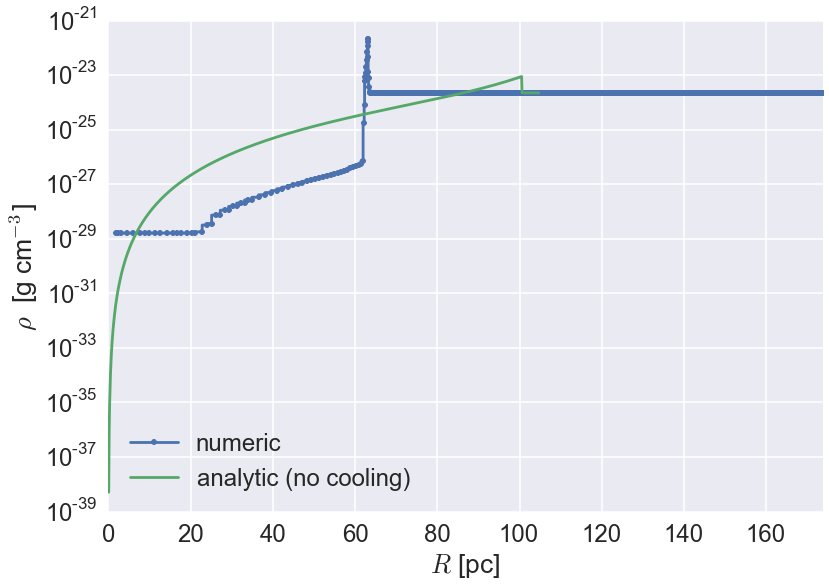

In [95]:
last_run = RunSummary()

data_dir = ''
# data_dir = 'saved_runs/riemann/BC_old/hydro/1e5yr/'
# data_dir = 'saved_runs/riemann/BC_old/hydro_with_cooling/1e6yr/' 
# data_dir = 'saved_runs/riemann/BC_new/hydro/1e5yr/'
# data_dir = 'saved_runs/riemann/BC_new/hydro_with_cooling/1e5yr/'

id = "" # you don't need the full uuid, just enough to distinguish it

single_run(data_dir=data_dir, id=id, last_run=last_run)

checkpoint:  saved_runs/riemann/Thornton_parameter_study/log_n_+00/log_Z_+00/T_10000/with_cooling/4d328fc8-8955-42bf-9ba1-a5e5343cb26a_checkpoint_0099.dat
time:  2349163.75136 [yr]
zones:  704
energy conserved to:  -0.981449789952
X conserved to:  -1.27531971342e-11


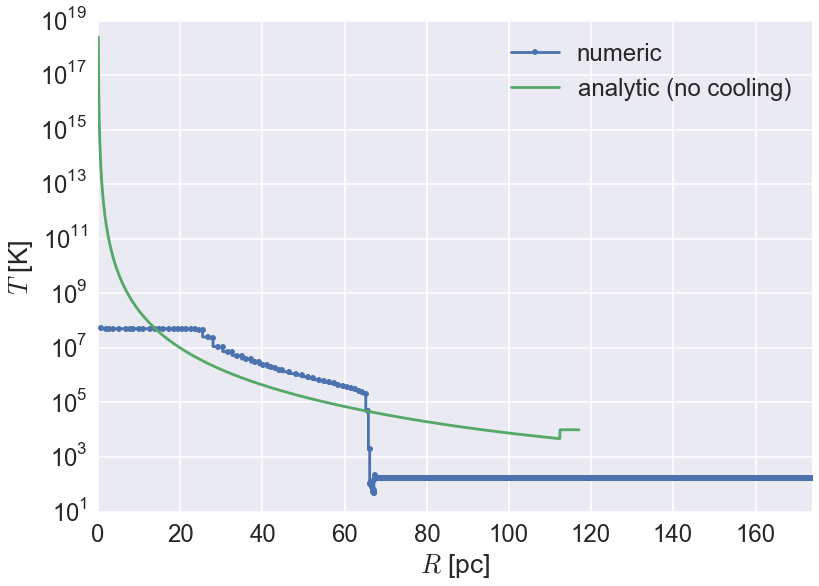

In [47]:
def parameter_study_wrapper(log_n, log_Z, T=1e4, 
                            with_cooling=True, 
                            last_run=last_run):
    z_solar = .02
    background_density     = 1.33 * m_proton * 10**log_n
    metallicity            = z_solar * 10**log_Z
    background_temperature = T
    data_dir = make_dirname_from_properties( background_density, 
                                             metallicity, 
                                             background_temperature,
                                             with_cooling)
    
    if os.path.isdir(data_dir):
        tmp = glob.glob(data_dir + "*checkpoint*.dat")        
        
        if len(tmp) is not 0:
            basename = os.path.basename(tmp[0])
            id = basename.split("checkpoint")[0]
            single_run(data_dir=data_dir, id=id, last_run=last_run)
            
        else:
            print("No data was found")
    else:
        print("No directory was found")

last_run = RunSummary()
        
interact_manual(parameter_study_wrapper,
        log_Z = FloatSlider(min=-3.0, max=+0.5, step=0.5, value=0),
        log_n = FloatSlider(min=-3.0, max=+3.0, step=0.5, value=0),
        T     = fixed(1e4),
        with_cooling = True, 
        last_run=fixed(last_run))

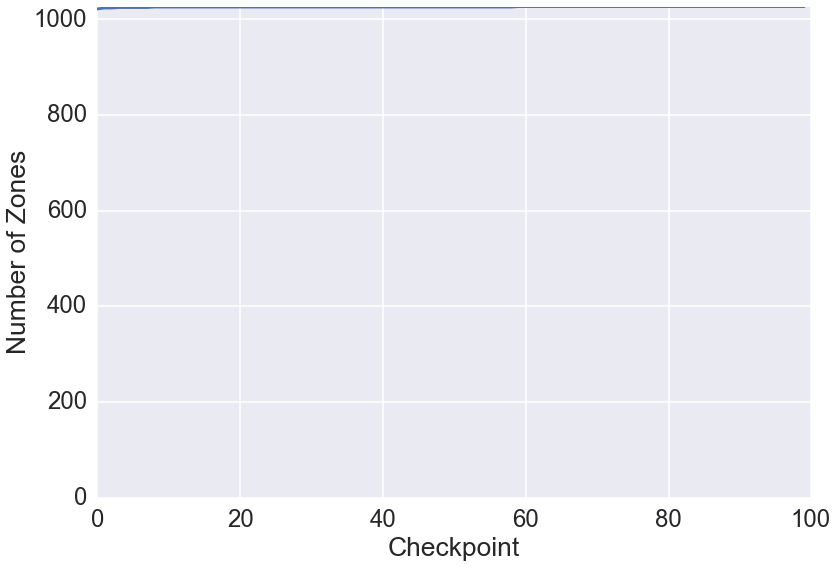

In [16]:
def plot_zones(last_run):
    if type(last_run) is RunSummary:
        if last_run.zones is not None:
            plt.plot(last_run.zones)
            plt.ylim(ymin=0)
            plt.ylabel("Number of Zones")
            plt.xlabel("Checkpoint")

plot_zones(last_run)

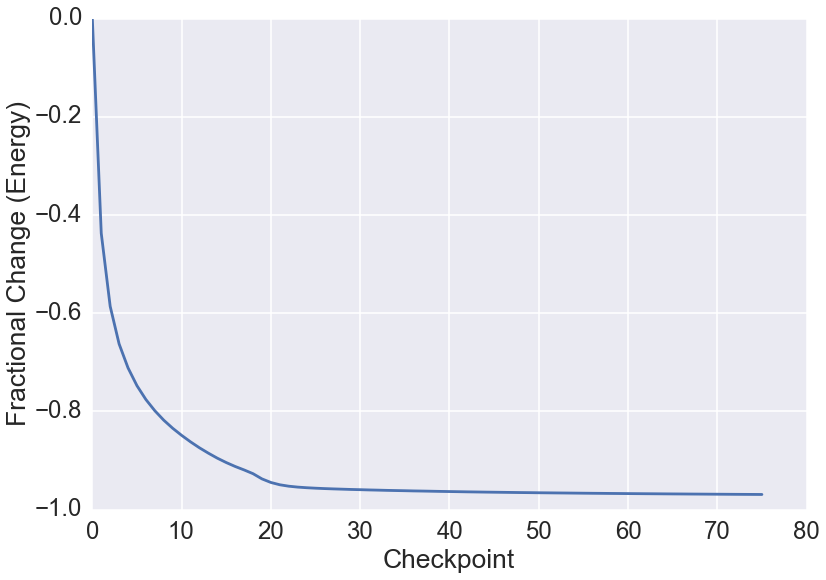

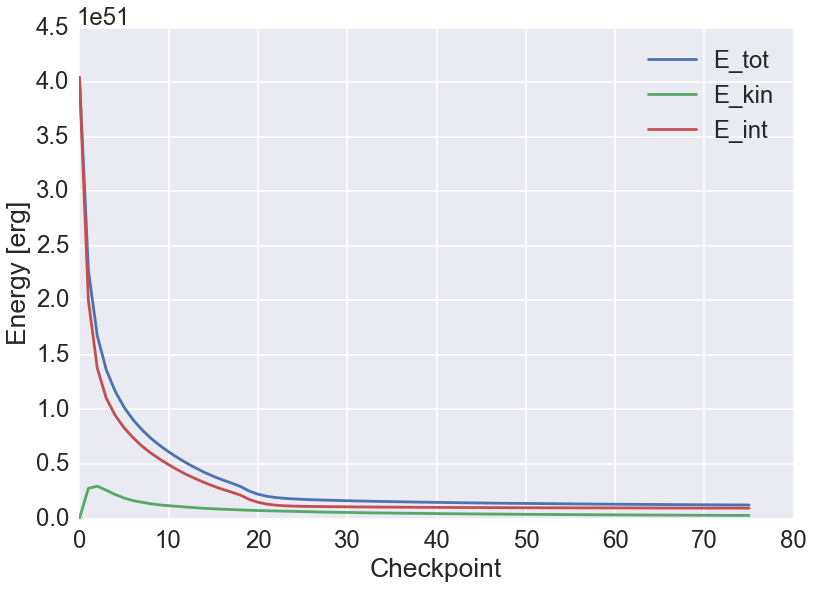

In [100]:
def plot_energy(last_run):
    if type(last_run) is RunSummary:
        if ( (last_run.E_tot is not None) and
             (last_run.E_int is not None) and
             (last_run.E_kin is not None) ):
            
            E_err = (last_run.E_tot - last_run.E_tot[0]) / last_run.E_tot[0]
#             print(last_run.E_tot)
#             plt.plot(abs(E_err))
#             plt.yscale("log")
            plt.plot(E_err)
            plt.xlabel("Checkpoint")    
            plt.ylabel("Fractional Change (Energy)")
        
            plt.figure()
            plt.plot(last_run.E_tot, label="E_tot" )
            plt.plot(last_run.E_kin, label="E_kin" )
            plt.plot(last_run.E_int, label="E_int" )
            plt.legend(loc="best")
            plt.xlabel("Checkpoint")    
            plt.ylabel("Energy [erg]")

plot_energy(last_run)



1

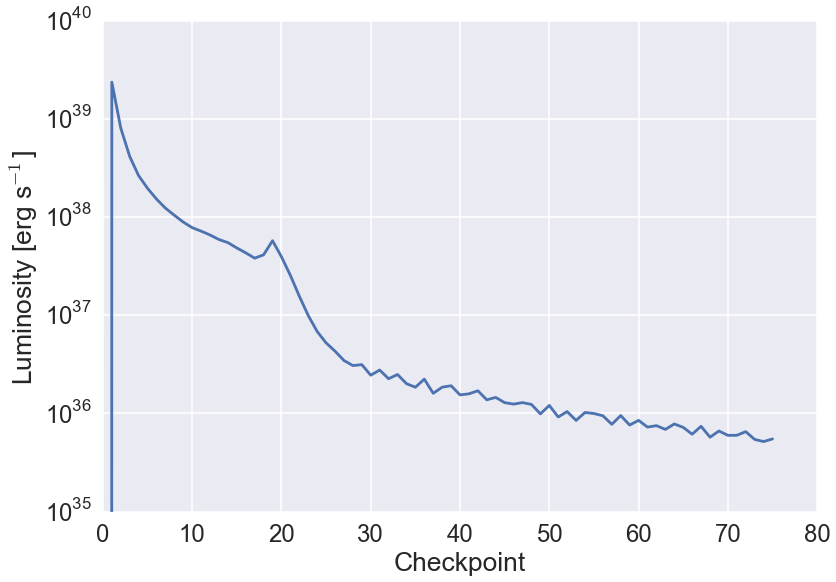

In [105]:
def plot_luminosity(last_run):
    if type(last_run) is RunSummary:
        plt.plot(last_run.Luminosity)
        plt.xlabel("Checkpoint")    
        plt.ylabel(r"Luminosity [erg s$^{-1}$]")
        plt.yscale("log")

plot_luminosity(last_run)
last_run.Luminosity.argmax()

In [106]:
high_res = RunSummary()
data_dir = ''
id = "8c8" # you don't need the full uuid, just enough to distinguish it
single_run(data_dir=data_dir, id=id, last_run=high_res)

low_res = RunSummary()
data_dir = ''
id = "3eac" # you don't need the full uuid, just enough to distinguish it
single_run(data_dir=data_dir, id=id, last_run=low_res)



plt.plot(1- (high_res.E_tot / low_res.E_tot), label="E_tot")
plt.plot(1- (high_res.E_kin / low_res.E_kin), label="E_kin")
plt.plot(1- (high_res.E_int / low_res.E_int), label="E_int")
plt.legend(loc="best")

IndexError: list index out of range